In [2]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from collections import Counter
import cv2
import convert_polygons as cp


import shapely.affinity as sa

In [3]:
image = cv2.imread("../images/test_ring.png", 0)
not image is None

True

In [4]:
c,h = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

len(c)

3

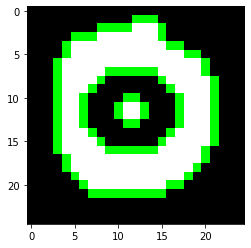

In [5]:
%matplotlib inline

test = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(test, c, -1, (0,255,0), 1)

plt.imshow(test)
plt.show()

In [6]:
import importlib as IL
from shapely.geometry import Polygon, LineString, Point, MultiLineString

In [7]:
IL.reload(cp)
p_list = cp.execute(image)

[(11, 10), (10, 11), (10, 12), (11, 13), (12, 13), (13, 12), (13, 11), (12, 10)] []
[(12, 1), (11, 2), (8, 2), (7, 3), (5, 3), (4, 4), (4, 5), (3, 6), (3, 16), (4, 17), (4, 18), (7, 21), (15, 21), (16, 20), (17, 20), (20, 17), (20, 16), (21, 15), (21, 8), (20, 7), (20, 6), (19, 5), (18, 5), (17, 4), (16, 4), (15, 3), (15, 2), (14, 1)] [[(9, 7), (14, 7), (17, 10), (17, 13), (14, 16), (9, 16), (6, 13), (6, 10)]]


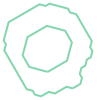

In [8]:
polygon = p_list[1]

new = sa.rotate(polygon,np.pi/6, use_radians=True)

MultiLineString([new.exterior]+list(new.interiors))

In [197]:
def plot_path(path):
    
    X = []
    Y = []
    
    
    if type(path[0]) == tuple or type(path[0]) == np.ndarray:
        
        for p in list(path):
            X.append(p[0])
            Y.append(p[1])

        plt.plot(X,Y)
    else:

        for p in list(path):
            X.append(p.x)
            Y.append(p.y)

        plt.plot(X,Y)

def plot_linestring(ls):
    
    X = []
    Y = []
    
    for p in list(ls.coords):
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

In [181]:

def find_peaks(contour):

    # check every point for peaks
    peaks = []

    rp0 = contour[-1:] + contour[0:-1]
    rp1 = contour
    rp2 = contour[1:] + contour[0:1]


    for p0, p1, p2 in zip(rp0,rp1,rp2):

        if p0.y == p2.y:
            peaks.append(p1)

    return peaks


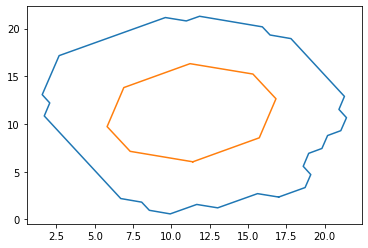

In [277]:
distance = 0.001


l1 = LineString(list(new.envelope.exterior.coords)[0:2])
l1 = l1.parallel_offset(0.5*distance, 'left')


test = MultiLineString([new.exterior]+list(new.interiors))

intersection_list = []
contour_list = []

for _ in range(len(test)):
    contour_list.append([])
    
while l1.intersects(new):
    
    intersections = []

    for i, x in enumerate(test):
        if l1.intersects(x):
            ip = list(x.intersection(l1))
            contour_list[i].extend(ip)    
            intersections.extend(ip)
    
    intersection_list.append(intersections)
    
    l1 = l1.parallel_offset(distance, 'left')

    
for i in range(len(intersection_list)):
    
    intersection_list[i].sort(key = lambda x: x.x)
    
# sort the contour points
for i in range(len(contour_list)):
    
    # sort the points by the projection distance
    contour_list[i].sort(key=test[i].project)
    
    # find the peaks in the contour
    peaks = find_peaks(contour_list[i])
    
    # remove the peaks from the contour and intersection list
    for p in peaks:
                
        contour_list[i].remove(p)
        
        for r, row in enumerate(intersection_list):
            if p in row:
                intersection_list[r].remove(p)
    
    
    plot_path(contour_list[i])

    
    


In [183]:
import contour_fill_shapely as cfs

In [184]:
def time_function(func):
    def inner(*arg):
        start = time.time()
        result = func(*arg)
        
        measured_time = time.time()-start
        
        print(func.__name__, measured_time)
        return result, measured_time
    return inner

In [275]:
%%time

import time
# get the next point

def next_point(point, contour_list, set_list, point_dict, new_row_y):
        
    strp = str(point)

    i1 = set_list[point_dict[strp]][strp]
    
    ring = contour_list[point_dict[strp]]
    
    i0 = i1-1
    i2 = i1+1
        
    # loop i2 around the ring if needed
    if i2 == len(ring):
        i2 = 0

    # check the previous point
    if ring[i0].y == new_row_y:
        return ring[i0]
    
    # check the next point
    if ring[i2].y == new_row_y:
        return ring[i2]    
    
    # if neither point returns
    return None
    
    
def across_point(point, row):
        
    index = row.index(point)
    
    if index % 2 == 0:
        return row[index+1]
    else:
        return row[index-1]

    
    
# find a point not in the path
def get_available_pt(total_path, intersection_list):
    
    mls = MultiLineString([LineString(p) for p in total_path])
    
    for row in intersection_list:
        for p in row:
            
            if mls.intersects(Point(p)):
                continue
            else:
                return p
    return None   
    
    
def fill_path(start, intersection_list, contour_list):
        
    # map point to a contour index
    point_dict = {}    
    for index, contour in enumerate(contour_list):
        point_dict = {**point_dict, **{str(key):index for key in contour}}
    
    # map point to index
    set_list = [{str(key):value for (value,key) in enumerate(contour)} for contour in contour_list]    
        
    p1 = start
    index = 0
    
    for i, row in enumerate(intersection_list):
        if start.y == row[0].y:
            index = i
            break
    
    path = []
    
    while not p1 is None:
        
        path.append(p1)
        p2 = across_point(p1, intersection_list[index])
        path.append(p2)
        index+=1
            
        if index == len(intersection_list):
            p1 = None
        else:
            p1 = next_point(p2, contour_list, set_list, point_dict, intersection_list[index][0].y)    
    
    return path
    

start = get_available_pt([], intersection_list)
total_path = []
while not start is None:
    total_path.append(fill_path(start, intersection_list, contour_list))
    start = get_available_pt(total_path, intersection_list)
    print(start)

POINT (13.03207152584044 1.206796769724491)
POINT (16.97368602791858 2.346796769724484)
POINT (4.47320187562917 6.036796769724406)


KeyboardInterrupt: 

42
8
280
206
96
10


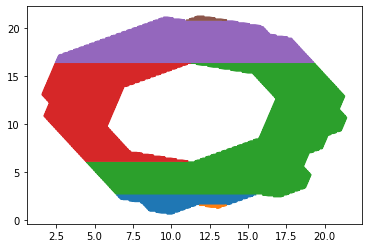

In [186]:

for path in total_path:
    print(len(path))
    plot_path(path)

In [187]:
'''
Testing speed boost with numba
'''

from numba import jit

13.5 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)
64228


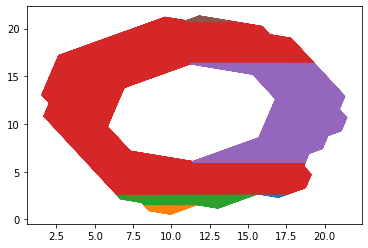

In [280]:
import time
# get the next point

@jit(nopython=True) 
def next_point(point, contour_indices, all_points):
        
    i1 = np.where((all_points[:,0] == point[0]) & (all_points[:,1]==point[1]))[0][0]
    
    i0 = i1-1
    i2 = i1+1    
    
    if i0 in contour_indices:
        i0 = contour_indices[np.where(i0 == contour_indices)[0][0]+1] -1
        
    elif i2 in contour_indices:
        i2 = contour_indices[np.where(i2 == contour_indices)[0][0]-1]

        
    # check the previous point
    if all_points[i0][1] > point[1]:
        return all_points[i0]
    
    # check the next point
    if all_points[i2][1] > point[1]:
        return all_points[i2]    
    
    # if neither point returns
    return None


@jit(nopython=True) 
def across_point(point, all_points): 
        
    row = all_points[all_points[:,1]==point[1]][:,0]

    row.sort()
        
    index = np.where((row == point[0]))[0][0]
        
    if index % 2 == 0:
        return np.array([row[index+1], point[1]])
    else:
        return np.array([row[index-1], point[1]])
    
    
# find a point not in the path
@jit(nopython=True)
def get_available_pt_index(last_start,total_path, all_points):
        
    for i in range(last_start, len(all_points)):
        if ((total_path[:,0] == all_points[i,0]) & (total_path[:,1] == all_points[i,1])).any():
            continue
        else:
            return i
    return -1   
    

@jit(nopython=True)  
def numba_mode(start_index, all_points, contour_indices):    
    
    p1 = all_points[start_index]
    index = start_index
    
    path = []
    
    while not p1 is None:
        
        path.append(p1)
        p2 = across_point(p1, all_points)
        
        path.append(p2)
        p1 = next_point(p2, contour_indices, all_points)    
        
    return path
    
def fill_path_numba(all_points, contour_indices):
    
    
    total_path = []
    temp = []
    start_index = 0
    
    sort_points = all_points[all_points[:,1].argsort()]
    
    last_start = 0
    
    
    while last_start != -1:

        path = numba_mode(start_index, all_points, contour_indices)
        
        temp.extend(path)
        
        last_start = get_available_pt_index(last_start,np.array(temp), sort_points)
        
        
        
        if last_start != -1:
            start_point = sort_points[last_start]

            # get the start index in all points
            start_index = np.where((all_points[:,0]==start_point[0]) & (all_points[:,1]==start_point[1]))[0][0]

        total_path.append(path)

    return total_path
    



if type(intersection_list[0][0]) == tuple:
    pass
else:
    for r, row in enumerate(intersection_list):
        for i, value in enumerate(row):
            intersection_list[r][i] = (value.x,value.y)
        
    for c, contour in enumerate(contour_list):
        for i, value in enumerate(contour):
            contour_list[c][i] = (value.x,value.y)


all_points = []
    
contour_indices = [0]

sum = 0
for contour in contour_list:
    sum+= len(contour)
    contour_indices.append(sum)
    
    for c in contour:
        all_points.append(c)


%timeit -n 3 result = fill_path_numba(np.array(all_points), np.array(contour_indices))


pts = 0
for path in result:
    plot_path(list(path))
    pts += len(path)
print(pts)

In [236]:
x = [(0,1),(1,1),(2,1),(1,2),(0,3), (1,3),(2,3)]
x = np.array(x, dtype=list)

In [237]:
x

array([[0, 1],
       [1, 1],
       [2, 1],
       [1, 2],
       [0, 3],
       [1, 3],
       [2, 3]], dtype=object)

In [159]:
x[:,1]==1

array([ True,  True,  True, False, False, False, False])

In [164]:
np.array(all_points)[0]

array([9.75121963, 0.62179677])

In [166]:
y = np.array([1,2,3,4,5,6])
y

array([1, 2, 3, 4, 5, 6])

In [260]:
np.where(y==1)[0][0]

0

In [240]:
((x[:,0] == 1) & (x[:,1] == 4)).any()

False